# Interaction Module 

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.ioff()

### ... qualitative module comparison

In [25]:
import itertools
import mantrap
import torch


env = mantrap.environment.Trajectron(ego_position=torch.zeros(2), ego_velocity=torch.zeros(2))
env.add_ado(position=torch.tensor([5, 5]), velocity=torch.tensor([0, -1]))

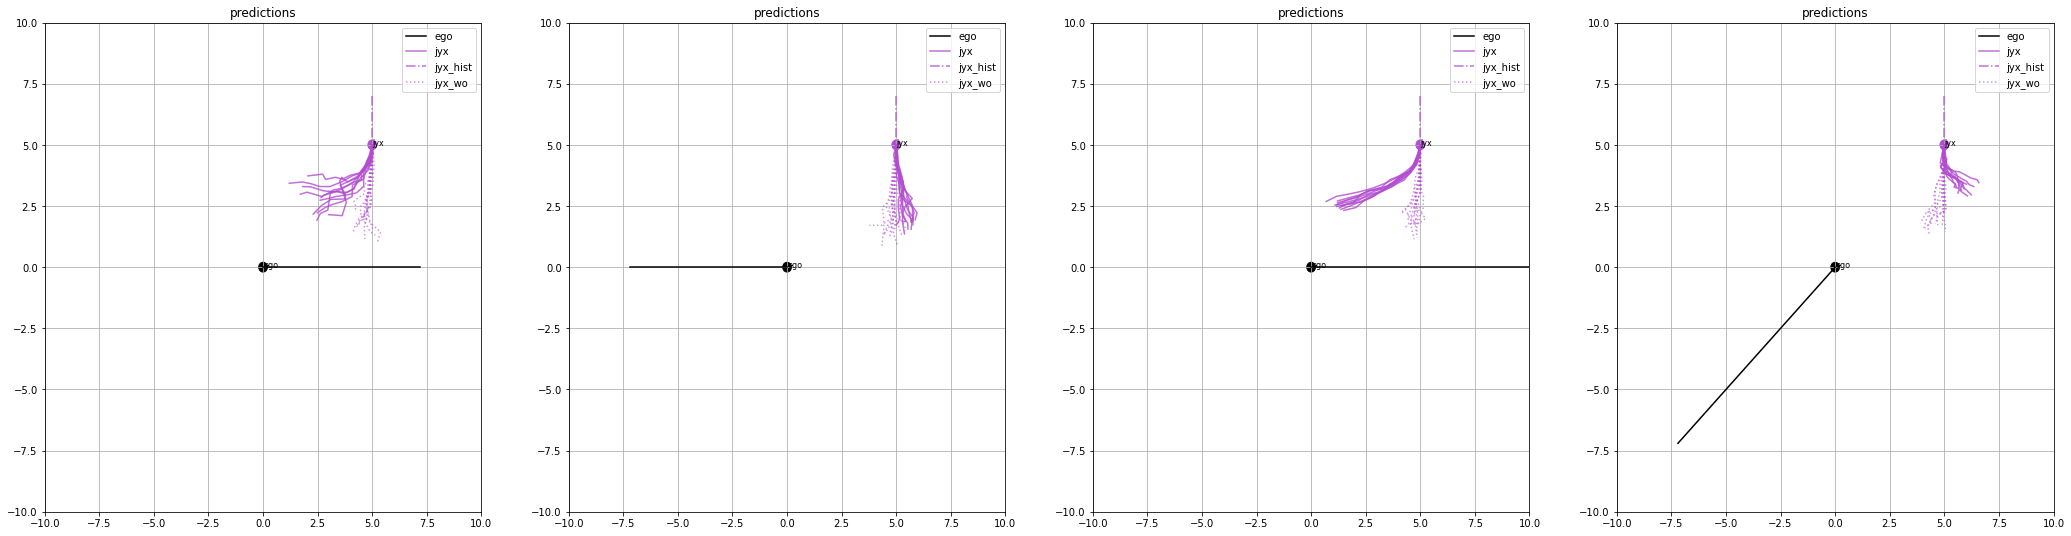

In [26]:
t_horizon = 10
controls_list = [torch.stack([torch.tensor([1, 0])] * t_horizon).float(), 
                 torch.stack([torch.tensor([-1, 0])] * t_horizon).float(), 
                 torch.stack([torch.tensor([2, 0])] * t_horizon).float(), 
                 torch.stack([torch.tensor([-1, -1])] * t_horizon).float()]

fig, ax = plt.subplots(1, len(controls_list), figsize=(len(controls_list) * 9, 9))
for i, ego_controls in enumerate(controls_list):
    env.visualize_prediction_w_controls(ego_controls, ax=ax[i], legend=True)
plt.show()

In [27]:
modules = [mantrap.modules.InteractionProbabilityModule, 
           mantrap.modules.baselines.InteractionPositionModule, 
           mantrap.modules.baselines.InteractionAccelerationModule]

for module_interact, ego_controls in itertools.product(modules, controls_list):
    module = module_interact(env=env, t_horizon=t_horizon)
    ego_trajectory = env.ego.unroll_trajectory(ego_controls, dt=env.dt)
    objective = module.objective(ego_trajectory, ado_ids=env.ado_ids, tag="test")
    
    print(f"{ego_controls[0, :].detach().numpy()}/{module.name} ==> {objective}")

[1. 0.]/interaction_prob ==> 2.8184397220611572
[-1.  0.]/interaction_prob ==> -4.619500160217285
[2. 0.]/interaction_prob ==> 50.0
[-1. -1.]/interaction_prob ==> 21.509368896484375
[1. 0.]/interaction_pos ==> 233.97970581054688
[-1.  0.]/interaction_pos ==> 146.94773864746094
[2. 0.]/interaction_pos ==> 329.5759582519531
[-1. -1.]/interaction_pos ==> 217.95223999023438
[1. 0.]/interact_acc ==> 98.9417495727539
[-1.  0.]/interact_acc ==> 86.2396011352539
[2. 0.]/interact_acc ==> 98.0596923828125
[-1. -1.]/interact_acc ==> 110.7919692993164


### quantitative module comparison

In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.ioff()

import mantrap
import mantrap_evaluation
import pandas as pd
import torch


env, goal, _ = mantrap_evaluation.scenarios.custom_passing(mantrap.environment.Trajectron)
modules = {"projection": mantrap.modules.InteractionProbabilityModule, 
           "diff_pos": mantrap.modules.baselines.InteractionPositionModule, 
           "diff_acc": mantrap.modules.baselines.InteractionAccelerationModule, 
           "none": None}

eval_df = pd.DataFrame()
num_eval = len(modules.keys())
fig, ax = plt.subplots(1, num_eval, figsize=(num_eval * 9, 9))
for i, (label, module) in enumerate(modules.items()): 
    print(f"Evaluating {label} ...")
    modules_hard = mantrap.solver.IPOPTSolver.module_hard()
    solver_modules = modules_hard + [module] if module is not None else modules_hard 
    solver = mantrap.solver.IPOPTSolver(env=env, goal=goal, modules=solver_modules)
    
    eval_df_k, ego_trajs, ado_trajs = mantrap_evaluation.evaluate(solver, label=label, num_tests=20)
    eval_df = eval_df.append(eval_df_k)
    mantrap.visualization.visualize_prediction(env=env, 
                                               ego_planned=torch.mean(ego_trajs, dim=0), 
                                               ado_planned=ado_trajs, 
                                               ego_goal=solver.goal, legend=True, ax=ax[i])

Evaluating projection ...
Evaluating diff_pos ...
Evaluating diff_acc ...
Evaluating none ...


In [3]:
eval_df

,ado_effort,directness,ego_effort,final_distance,minimal_distance,runtime[s]
projection,8.973712,0.428876,0.772783,0.721374,3.540611,1.215327
diff_pos,8.429550,0.971910,0.578497,0.237680,1.755074,0.781663
diff_acc,8.321511,0.845362,0.514306,0.471517,1.852438,1.169627
none,8.143216,1.000000,0.273420,0.234035,1.809781,0.104818


In [4]:
plt.savefig("/Users/sele/Desktop/inter_comp_multi.png")

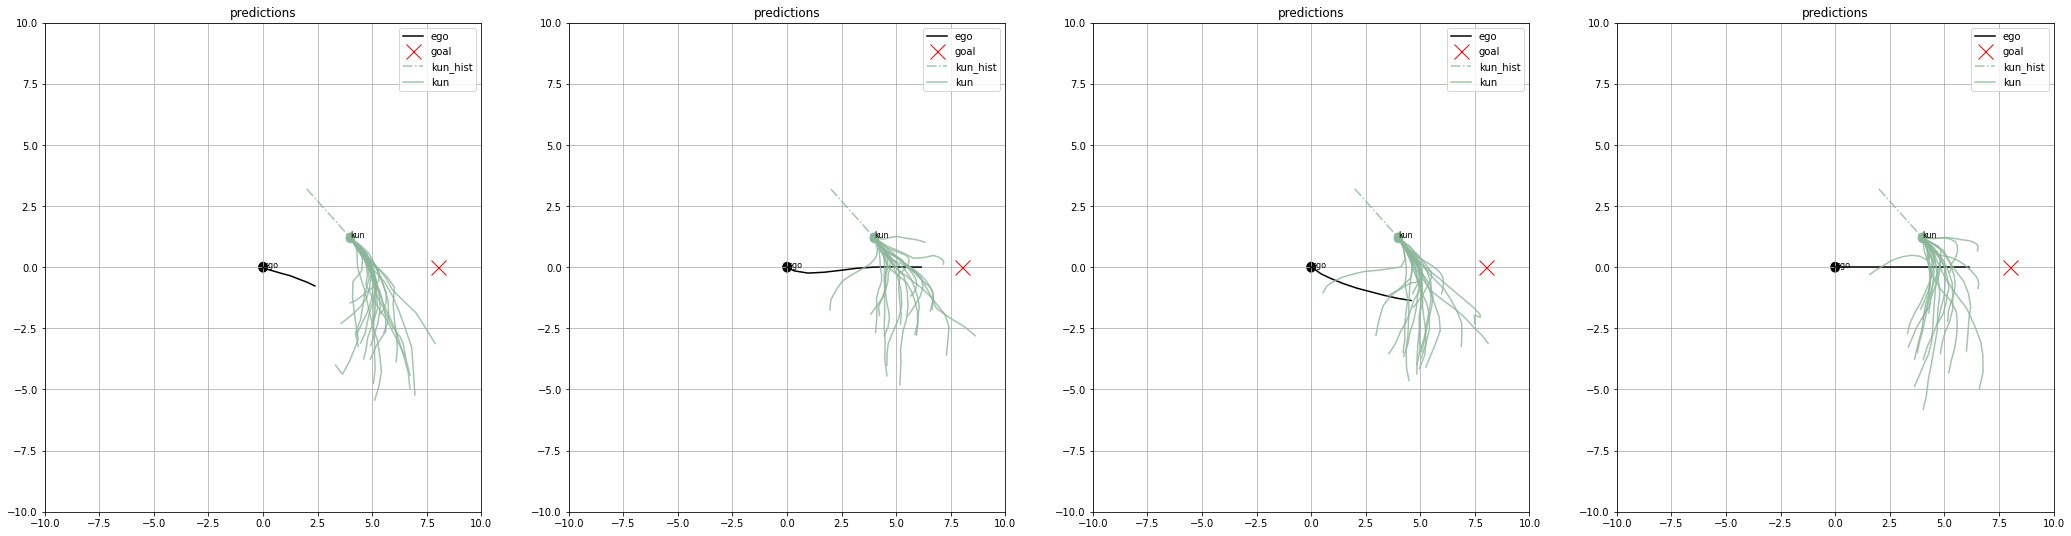

In [5]:
plt.show()